In [1]:
import rasterio 
import rasterio.mask
import geopandas as gpd
import fiona
import os
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import plot, show, savefig, xlim, figure, \
                 ylim, legend, boxplot, setp, axes
import matplotlib.patches as mpatches
import matplotlib as mpl

def mkdir(dir):
    
    if not os.path.exists(dir):
        os.mkdir(dir)
        
path_run = os.getcwd() + '/'
path_data_processed = path_run + 'data_processed/'
path_plots = path_run + 'plots/'
path_plots_creator = mkdir(path_plots)

results = pd.DataFrame()

for filename in sorted(os.listdir(f"{path_data_processed}affected_people/")):
    print(filename)
    results_temp = pd.read_csv(f"{path_data_processed}affected_people/" + filename)
    results = results.append(results_temp)

/home/mester/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


results_max_100_wind_final.csv
results_mean_100_wind_final.csv
results_min_100_wind_final.csv
results_no_100_wind_final.csv


In [6]:
results

,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf
0,factual,max,100,1255083,1402400.0,1101421.0,325147.0,0.0
1,factualwind880,max,100,1219789,1434485.0,1133507.0,356300.0,0.0
2,factualwind880zos070,max,100,1217729,1435040.0,1134061.0,356797.0,0.0
3,factualwind880zos170,max,100,1211913,1437987.0,1136709.0,359325.0,0.0
4,factualwind915,max,100,1233330,1424776.0,1123524.0,346859.0,0.0
...,...,...,...,...,...,...,...,...
67,factualzos150,no,100,1230305,1422643.0,1121347.0,344496.0,0.0
68,factualzos155,no,100,1229928,1422983.0,1121687.0,344803.0,0.0
69,factualzos160,no,100,1229928,1422983.0,1121687.0,344803.0,0.0
70,factualzos165,no,100,1228710,1424202.0,1122879.0,345995.0,0.0


In [2]:
results['scenario'] = results['scenario'].str.replace('cf','factual')

displacements_IDMC = 478169

def cf_group(x):

    
        print(x)

        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind' or x == 'factualwind880' or x == 'factualwind915' or x == 'factualwind940':
            group = 2
            
        if 'factualwindzos' in x or 'factualwind880zos' in x or 'factualwind915zos' in x or 'factualwind940zos' in x:
            group = 3
            
        return(group)
    
#         print(x)

#         if x == 'factual':
#             group = 0
            
#         if 'factualzos' in x:
#             group = 1
            
#         if x == 'factualwind880':
#             group = 2
            
#         if 'factualwind880zos'in x:
#             group = 3
            
#         return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))          
results_ext = pd.DataFrame()

for tide in ['no','mean','max','min']:
    
    for threshold in [100]:
#    for threshold in [10,50,100]:

        results_temp = results[results['tide']==tide]
        results_temp = results_temp[results_temp['threshold']==threshold]
        factual_temp_value = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp_value - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],4)

        results_temp['cf_group'] = results_temp['scenario'].apply(lambda x: cf_group(x))
        results_temp.loc[:,'affected_flood_wind'] = results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96']
        results_temp.loc[:,'affected_flood_wind_cf'] = results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96_cf']

        factual_temp = results_temp[results_temp['scenario']=='factual']
        factual_temp.loc[:,'displacements'] = displacements_IDMC

        non_factual_temp = results_temp[results_temp['scenario']!='factual']
        results_temp_remerged = factual_temp.append(non_factual_temp)
        results_temp_remerged.loc[:,'vulnerability'] = (factual_temp['displacements']/factual_temp['affected']).iloc[0]
        results_temp_remerged.loc[:,'displacements'] = round(results_temp_remerged['vulnerability']*results_temp_remerged['affected'],0)
        results_temp_remerged.loc[:,'displacements_dif'] = displacements_IDMC - results_temp_remerged['displacements']
        results_temp_remerged.loc[:,'displacements_dif_perc'] = np.round(100*results_temp_remerged['displacements_dif']/results_temp_remerged['displacements'],4)
        
        results_temp_remerged.loc[:,'vulnerability_flood_wind'] = (factual_temp['displacements']/factual_temp['affected_flood_wind']).iloc[0]
        results_temp_remerged.loc[:,'displacements_flood_wind_cf'] = round(results_temp_remerged['affected_flood_wind_cf'] * results_temp_remerged['vulnerability_flood_wind'],0)
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif'] = displacements_IDMC - results_temp_remerged['displacements_flood_wind_cf'] 
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif_perc_of_tot_disp'] = np.round(100*results_temp_remerged['displacements_flood_wind_cf_dif']/displacements_IDMC,4)
 
        results_ext = results_ext.append(results_temp_remerged)
        
results_ext.reset_index(inplace=True)                       
results_ext

factual
factualwind880
factualwind880zos070
factualwind880zos170
factualwind915
factualwind915zos065
factualwind915zos070
factualwind915zos075
factualwind915zos080
factualwind915zos085
factualwind915zos090
factualwind915zos095
factualwind915zos100
factualwind915zos105
factualwind915zos110
factualwind915zos115
factualwind915zos120
factualwind915zos125
factualwind915zos130
factualwind915zos135
factualwind915zos140
factualwind915zos145
factualwind915zos150
factualwind915zos155
factualwind915zos160
factualwind915zos165
factualwind915zos170
factualwind940
factualwind940zos070
factualwind940zos090
factualwind940zos110
factualwind940zos130
factualwind940zos150
factualwind940zos170
factualwind
factualwindzos065
factualwindzos070
factualwindzos075
factualwindzos080
factualwindzos085
factualwindzos090
factualwindzos095
factualwindzos100
factualwindzos105
factualwindzos110
factualwindzos115
factualwindzos120
factualwindzos125
factualwindzos130
factualwindzos135
factualwindzos140
factualwindzos145

/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/mester/anaconda3/envs/ipykernel_py3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a c

,index,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
0,0,factual,no,100,1237744,1416277.0,1114981.0,338296.0,0.0,0,...,1576040.0,1237744.0,478169.0,0.386323,0.0,0.0000,0.303399,375530.0,102639.0,21.4650
1,1,factualwind880zos090,no,100,1205063,1439589.0,1138266.0,360518.0,0.0,3,...,1565581.0,1205063.0,465544.0,0.386323,12625.0,2.7119,0.303399,365615.0,112554.0,23.5385
2,2,factualwind880zos170,no,100,1204265,1440386.0,1139064.0,361098.0,0.0,3,...,1565363.0,1204265.0,465235.0,0.386323,12934.0,2.7801,0.303399,365373.0,112796.0,23.5891
3,3,factualwind915,no,100,1215950,1434557.0,1133233.0,355879.0,0.0,2,...,1571829.0,1215950.0,469749.0,0.386323,8420.0,1.7924,0.303399,368918.0,109251.0,22.8478
4,4,factualwind915zos065,no,100,1205892,1437330.0,1136006.0,358396.0,0.0,3,...,1564288.0,1205892.0,465864.0,0.386323,12305.0,2.6413,0.303399,365866.0,112303.0,23.4860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,63,factualzos150,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564
286,64,factualzos155,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564
287,65,factualzos160,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564
288,66,factualzos165,min,100,1205151,1433554.0,1132161.0,355029.0,0.0,1,...,1560180.0,1205151.0,477793.0,0.396459,376.0,0.0787,0.306480,369355.0,108814.0,22.7564


In [16]:
results

,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group
0,factual,max,100,1255083,1402400.0,1101421.0,325147.0,0.0,0
1,factualwind880,max,100,1219789,1434485.0,1133507.0,356300.0,0.0,2
2,factualwind880zos070,max,100,1217729,1435040.0,1134061.0,356797.0,0.0,3
3,factualwind880zos170,max,100,1211913,1437987.0,1136709.0,359325.0,0.0,3
4,factualwind915,max,100,1233330,1424776.0,1123524.0,346859.0,0.0,2
...,...,...,...,...,...,...,...,...,...
67,factualzos150,no,100,1230305,1422643.0,1121347.0,344496.0,0.0,1
68,factualzos155,no,100,1229928,1422983.0,1121687.0,344803.0,0.0,1
69,factualzos160,no,100,1229928,1422983.0,1121687.0,344803.0,0.0,1
70,factualzos165,no,100,1228710,1424202.0,1122879.0,345995.0,0.0,1


In [13]:
# # Values 100 cm + max tide

# results_temp = results_ext[(results_ext.tide == 'max') & (results_ext.threshold == 100)] 
# results_temp[results_temp.scenario.str.contains('windzos')].median()

In [15]:
# 400 cm

for tide in ['no','mean','max','min']:
    
    for threshold in [400]:

        results_temp = results[results['tide']==tide]
        results_temp = results_temp[results_temp['threshold']==threshold]
        factual_temp_value = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = np.nan # factual_temp_value - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.nan # np.round(100*results_temp['affected_dif']/results_temp['affected'],4)

        results_temp['cf_group'] = results_temp['scenario'].apply(lambda x: cf_group(x))
        results_temp.loc[:,'affected_flood_wind'] = np.nan # results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96']
        results_temp.loc[:,'affected_flood_wind_cf'] = np.nan # results_temp.loc[:,'affected'] + results_temp.loc[:,'affected_wind_96_cf']

        factual_temp = results_temp[results_temp['scenario']=='factual']
        factual_temp.loc[:,'displacements'] = displacements_IDMC

        non_factual_temp = results_temp[results_temp['scenario']!='factual']
        results_temp_remerged = factual_temp.append(non_factual_temp)
        results_temp_remerged.loc[:,'vulnerability'] = np.nan #(factual_temp['displacements']/factual_temp['affected']).iloc[0]
        results_temp_remerged.loc[:,'displacements'] = results_temp_remerged['affected'] # round(results_temp_remerged['vulnerability']*results_temp_remerged['affected'],0)
        results_temp_remerged.loc[:,'displacements_dif'] = displacements_IDMC - results_temp_remerged['affected']
        results_temp_remerged.loc[:,'displacements_dif_perc'] = np.round(100*results_temp_remerged['displacements_dif']/results_temp_remerged['displacements'],4)
        
        results_temp_remerged.loc[:,'vulnerability_flood_wind'] = np.nan # (factual_temp['displacements']/factual_temp['affected_flood_wind']).iloc[0]
        results_temp_remerged.loc[:,'displacements_flood_wind_cf'] = np.nan # round(results_temp_remerged['affected_flood_wind_cf'] * results_temp_remerged['vulnerability_flood_wind'],0)
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif'] = np.nan # displacements_IDMC - results_temp_remerged['displacements_flood_wind_cf'] 
        results_temp_remerged.loc[:,'displacements_flood_wind_cf_dif_perc_of_tot_disp'] = np.nan #np.round(100*results_temp_remerged['displacements_flood_wind_cf_dif']/displacements_IDMC,4)
 
        results_ext = results_ext.append(results_temp_remerged)
        
results_ext.reset_index(inplace=True)    

IndexError: single positional indexer is out-of-bounds

In [15]:
#results_temp[results_temp.scenario == 'factual']

,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group,affected_dif,affected_dif_perc
0,factual,max,400,475577,1510586.0,1195843.0,378469.0,0.0,0,0,0.00
1,factualwind,max,400,486055,1516173.0,1201429.0,383820.0,0.0,2,-10478,-2.16
2,factualwindzos065,max,400,479562,1516173.0,1201429.0,383820.0,0.0,3,-3985,-0.83
3,factualwindzos070,max,400,479537,1516173.0,1201429.0,383820.0,0.0,3,-3960,-0.83
4,factualwindzos075,max,400,479537,1516173.0,1201429.0,383820.0,0.0,3,-3960,-0.83
5,factualwindzos080,max,400,479562,1516173.0,1201429.0,383820.0,0.0,3,-3985,-0.83
6,factualwindzos085,max,400,479537,1516173.0,1201429.0,383820.0,0.0,3,-3960,-0.83
7,factualwindzos090,max,400,479537,1516173.0,1201429.0,383820.0,0.0,3,-3960,-0.83
8,factualwindzos095,max,400,479537,1516173.0,1201429.0,383820.0,0.0,3,-3960,-0.83
9,factualwindzos100,max,400,479537,1516173.0,1201429.0,383820.0,0.0,3,-3960,-0.83


In [5]:
results_ext

,level_0,index,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,...,affected_flood_wind,affected_flood_wind_cf,displacements,vulnerability,displacements_dif,displacements_dif_perc,vulnerability_flood_wind,displacements_flood_wind_cf,displacements_flood_wind_cf_dif,displacements_flood_wind_cf_dif_perc_of_tot_disp
0,0,0.0,factual,no,10,2047946,1143302.0,848656.0,123937.0,0.0,...,2171883.0,2047946.0,478169.0,0.233487,0.0,0.0000,0.220163,450883.0,27286.0,5.7064
1,1,1.0,factualwind,no,10,1786714,1334355.0,1039461.0,310520.0,0.0,...,2097234.0,1786714.0,417175.0,0.233487,60994.0,14.6207,0.220163,393369.0,84800.0,17.7343
2,2,2.0,factualwindzos065,no,10,1768112,1343009.0,1047986.0,318753.0,0.0,...,2086865.0,1768112.0,412831.0,0.233487,65338.0,15.8268,0.220163,389273.0,88896.0,18.5909
3,3,3.0,factualwindzos070,no,10,1766787,1343011.0,1047988.0,318753.0,0.0,...,2085540.0,1766787.0,412522.0,0.233487,65647.0,15.9136,0.220163,388982.0,89187.0,18.6518
4,4,4.0,factualwindzos075,no,10,1766787,1343011.0,1047988.0,318753.0,0.0,...,2085540.0,1766787.0,412522.0,0.233487,65647.0,15.9136,0.220163,388982.0,89187.0,18.6518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,41,NaN,factualzos150,min,400,483288,1511852.0,1197109.0,379734.0,0.0,...,NaN,NaN,483288.0,NaN,-5119.0,-1.0592,NaN,NaN,NaN,NaN
732,42,NaN,factualzos155,min,400,483288,1511852.0,1197109.0,379734.0,0.0,...,NaN,NaN,483288.0,NaN,-5119.0,-1.0592,NaN,NaN,NaN,NaN
733,43,NaN,factualzos160,min,400,483288,1511852.0,1197109.0,379734.0,0.0,...,NaN,NaN,483288.0,NaN,-5119.0,-1.0592,NaN,NaN,NaN,NaN
734,44,NaN,factualzos165,min,400,483288,1511852.0,1197109.0,379734.0,0.0,...,NaN,NaN,483288.0,NaN,-5119.0,-1.0592,NaN,NaN,NaN,NaN


In [4]:
results_ext.to_csv(path_data_processed + 'all_results.csv')

In [25]:
# flooding

print('flooding \n')

results_ext_temp = results_ext[results_ext['tide']=='max']
results_ext_temp = results_ext_temp[results_ext_temp['threshold']==100]
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]

print('Median % change for max:',round(np.median(results_ext_temp['affected_dif_perc']),1))
print('5th quantile % change for max:',round(results_ext_temp['affected_dif_perc'].quantile(0.05),1))
print('95th quantile % change for max:',round(results_ext_temp['affected_dif_perc'].quantile(0.95),1))
print('Max. change in displacements for max:',round(np.max(results_ext_temp['displacements_dif']),-2))
# print('Median change in affected for max:',round(np.median(results_ext_temp['affected_dif']),-2))
print('Max. change in affected for max:',round(np.max(results_ext_temp['affected_dif']),-2),'\n')

results_ext_temp = results_ext[results_ext['tide']=='no']
results_ext_temp = results_ext_temp[results_ext_temp['threshold']==100]
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]


print('Median % change for no:',round(np.median(results_ext_temp['affected_dif_perc']),1))
print('5th quantile % change for no:',round(results_ext_temp['affected_dif_perc'].quantile(0.05),1))
print('95th quantile % change for no:',round(results_ext_temp['affected_dif_perc'].quantile(0.95),1))
print('Max. change in displacements for no:',round(np.max(results_ext_temp['displacements_dif']),-2))
# print('Median change in affected for no:',round(np.median(results_ext_temp['affected_dif']),-2))
print('Max. change in affected for no:',round(np.max(results_ext_temp['affected_dif']),-2),'\n')

# all depth thresholds

print('All depth thresholds \n')

results_ext_temp = results_ext[results_ext['tide']=='max']
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]

print('Max overall change in displacements:', round(np.max(results_ext.sort_values('displacements_dif',ascending=False)['displacements_dif']),-2))                                                  
print('Max overall change in %:',round(np.max(results_ext.sort_values('displacements_dif_perc',ascending=False)['displacements_dif_perc']),1),'\n')                                                
                              
    
# wind

print('wind - max tide \n')
results_ext_temp = results_ext[results_ext['tide']=='max']
results_ext_temp = results_ext_temp[results_ext_temp['threshold']==100]
results_ext_temp = results_ext_temp[results_ext_temp['cf_group']==3]

print("min number of affected:",round(np.min(results_ext_temp.sort_values('affected_wind_96',ascending=False)['affected_wind_96']),-2))
print("max number of affected:",round(np.max(results_ext_temp.sort_values('affected_wind_96',ascending=False)['affected_wind_96']),-2),'\n')

print('min number of displacements:',round(np.min(results_ext_temp.sort_values('displacements_flood_wind_cf_dif',ascending=False)['displacements_flood_wind_cf_dif']),-2))
print('max number of displacements:',round(np.max(results_ext_temp.sort_values('displacements_flood_wind_cf_dif',ascending=False)['displacements_flood_wind_cf_dif']),-2),'\n')


print("min % of all displacements:",round(np.min(results_ext_temp.sort_values('displacements_flood_wind_cf_dif_perc_of_tot_disp',ascending=False)['displacements_flood_wind_cf_dif_perc_of_tot_disp']),1))
print("max % of all displacements:",round(np.max(results_ext_temp.sort_values('displacements_flood_wind_cf_dif_perc_of_tot_disp',ascending=False)['displacements_flood_wind_cf_dif_perc_of_tot_disp']),1),'\n')

flooding 

Median % change for max: 3.1
5th quantile % change for max: 2.9
95th quantile % change for max: 3.5
Max. change in displacements for max: 16500.0
Max. change in affected for max: 43300 

Median % change for no: 3.5
5th quantile % change for no: 3.3
95th quantile % change for no: 3.7
Max. change in displacements for no: 17100.0
Max. change in affected for no: 44300 

All depth thresholds 

Max overall change in displacements: 69800.0
Max overall change in %: 17.1 

wind - max tide 

min number of affected: 354400.0
max number of affected: 357400.0 

min number of displacements: 109200.0
max number of displacements: 111500.0 

min % of all displacements: 22.8
max % of all displacements: 23.3 



# Plot

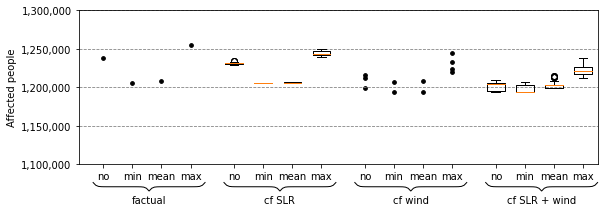

In [43]:
# Affected people - 100 cm

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(3)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Affected people')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==0]
        results_temp_list.append(list(results_temp_cf_group['affected']))
        
    plt.scatter([0,1,2,3],results_temp_list,color='black',s=14)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_2 = boxplot(results_temp_list,positions = [4.5,5.5,6.5,7.5],widths = 0.6)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    plt.scatter([9,9,9],results_temp_list[0],color='black',s=14)
    plt.scatter([10,10],results_temp_list[1],color='black',s=14)
    plt.scatter([11,11],results_temp_list[2],color='black',s=14)
    plt.scatter([12,12,12,12],results_temp_list[3],color='black',s=14)
#    bp_1 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_3 = boxplot(results_temp_list,positions = [13.5,14.5,15.5,16.5],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12, 13.5,14.5,15.5,16.5])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .015)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.01*yspan, text, ha='center', va='bottom')
    dif = -1061000
    draw_brace(ax1, (-0.35,3.5),dif, 'factual')
    draw_brace(ax1, (4.15,8.0),dif, 'cf SLR')
    draw_brace(ax1, (8.65,12.5),dif, 'cf wind')
    draw_brace(ax1, (13.15,17),dif, 'cf SLR + wind')

    ylim(1_100_000,1_300_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

fig.tight_layout()

#fig.savefig(f"{path_plots}/plot_all_tides_affected_people_100.png",dpi=300)

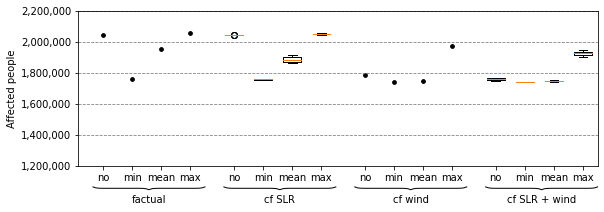

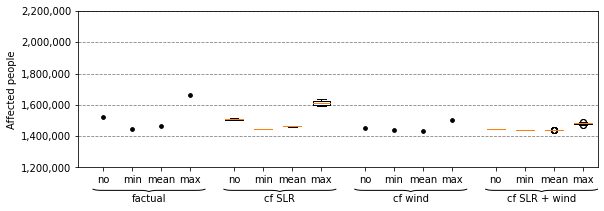

In [7]:
# Affected people - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

threshold_counter = 0

for threshold in [10,50]:
    fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)

    ax1.set_ylabel('Affected people')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==0]
        results_temp_list.append(list(results_temp_cf_group['affected']))
    
    plt.scatter([0,1,2,3],results_temp_list,color='black',s=14)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_2 = boxplot(results_temp_list,positions = [4.5,5.5,6.5,7.5],widths = 0.6)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    plt.scatter([9,10,11,12],results_temp_list,color='black',s=14)
    
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected']))

    bp_3 = boxplot(results_temp_list,positions = [13.5,14.5,15.5,16.5],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12, 13.5,14.5,15.5,16.5])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .015)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.04*yspan, text, ha='center', va='bottom')
    dif = -1040000
    draw_brace(ax1, (-0.35,3.5),dif, 'factual')
    draw_brace(ax1, (4.15,8.0),dif, 'cf SLR')
    draw_brace(ax1, (8.65,12.5),dif, 'cf wind')
    draw_brace(ax1, (13.15,17),dif, 'cf SLR + wind')

    ylim(1_200_000,2_200_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_affected_people_{threshold}.png",dpi=300)

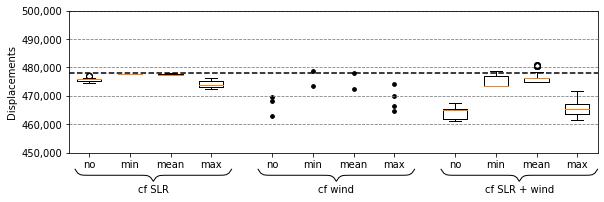

In [45]:
# Displacements - 100 cm

for threshold in [100]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)

    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['displacements']))

  #  plt.scatter([4.5,5.5,6.5,7.5],results_temp_list,color='black',s=10)
    plt.scatter([4.5,4.5,4.5],results_temp_list[0],color='black',s=14)
    plt.scatter([5.5,5.5],results_temp_list[1],color='black',s=14)
    plt.scatter([6.5,6.5],results_temp_list[2],color='black',s=14)
    plt.scatter([7.5,7.5,7.5,7.5],results_temp_list[3],color='black',s=14)
    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.011*yspan, text, ha='center', va='bottom')
        
    dif = -441000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(450_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')
    
    fig.tight_layout()

    #fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

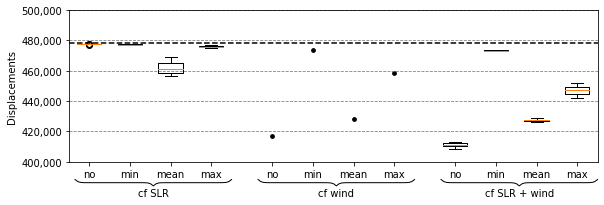

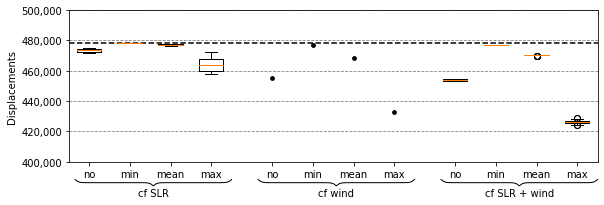

In [11]:
# Displacements - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

for threshold in [10,50]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]
        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['displacements']))

    plt.scatter([4.5,5.5,6.5,7.5],results_temp_list,color='black',s=14)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')

    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.017*yspan, text, ha='center', va='bottom')
        
    dif = -385000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(400_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

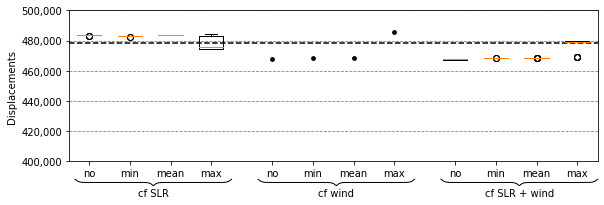

In [19]:
# 400

# Displacements - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

for threshold in [400]:
    
    fig = plt.figure(figsize =(8.5,3.0), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_ylabel('Displacements')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]
        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['displacements']))

    plt.scatter([4.5,5.5,6.5,7.5],results_temp_list,color='black',s=14)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results_ext[results_ext['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['displacements']))
        
    bp_3 = boxplot(results_temp_list,positions = [9,10,11,12],widths = 0.6)
    
    ax1.set_xticks([0,1,2,3, 4.5,5.5,6.5,7.5, 9,10,11,12])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')

    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.008*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.017*yspan, text, ha='center', va='bottom')
        
    dif = -385000
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (4.15,8.0),dif, 'cf wind')
    draw_brace(ax1, (8.65,12.5),dif, 'cf SLR + wind')

    ylim(400_000,500_000)
    ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    ax1.axhline(y=478169, color='black', linestyle='--')

    fig.tight_layout()

  #  fig.savefig(f"{path_plots}/plot_all_tides_displacements_{threshold}.png",dpi=300)

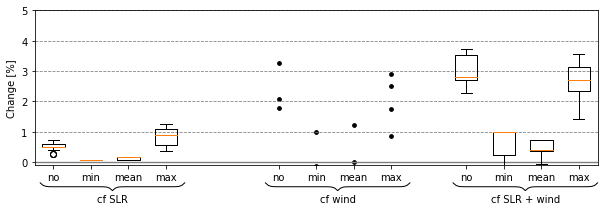

In [47]:
# Change affected people - 100 cm

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([100],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,6,6],results_temp_list[0],color='black',s=14)
    plt.scatter([7,7],results_temp_list[1],color='black',s=14)
    plt.scatter([8,8],results_temp_list[2],color='black',s=14)
    plt.scatter([9,9,9,9],results_temp_list[3],color='black',s=14)
    
    #plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)


    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,5)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),0.6, 'cf wind')
    draw_brace(ax1, (10.65,14.5),0.6, 'cf SLR + wind')
    
fig.tight_layout()

#fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)

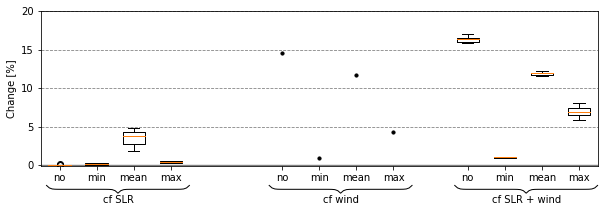

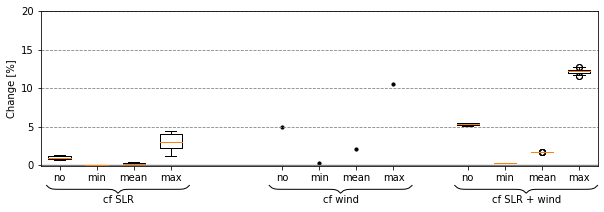

In [9]:
# Change affected people - 10 cm / 50 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

for threshold in [10,50]:
    fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    # first boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        
    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)

    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-0.1,20)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y + .05)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.20*yspan, text, ha='center', va='bottom')
        
    dif = 1.1
    draw_brace(ax1, (-0.35,3.5),dif, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),dif, 'cf wind')
    draw_brace(ax1, (10.65,14.5),dif, 'cf SLR + wind')

    fig.tight_layout()

    fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_{threshold}.png",dpi=300)

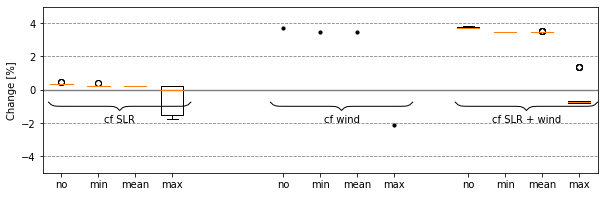

In [20]:
# 400

# Change affected people - 100 cm

def cf_group(x):
    
        if x == 'factual':
            group = 0
            
        if 'factualzos' in x:
            group = 1
            
        if x == 'factualwind':
            group = 2
            
        if 'factualwindzos' in x:
            group = 3            
        return(group)

results['cf_group'] = results['scenario'].apply(lambda x: cf_group(x))

fig = plt.figure(figsize =(8.5,8), linewidth = 9) ##16,4  8,8

for threshold,threshold_counter in zip([400],range(1)):

    def setBoxColors(bp):
        setp(bp['medians'][0], color='black')

    ax1 = fig.add_subplot(3, 1, threshold_counter+1)
    ax1.set_ylabel('Change [%]')
    ax1.axhline(color='gray',linewidth=1.4)

    results_temp_list = []

    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==1]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))
        


    bp_1 = boxplot(results_temp_list,positions = [0,1,2,3],widths = 0.6)

    # second boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==2]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    plt.scatter([6,7,8,9],results_temp_list,color='black',s=10)


    # third boxplot pair
    results_temp_list = []


    for tide in ['no','min','mean','max']:
    
        results_temp = results[results['threshold']==threshold]
        results_temp = results_temp[results_temp['tide']==tide]

        factual_temp = results_temp[results_temp['scenario']=='factual']['affected'].iloc[0]
        results_temp.loc[:,'affected_dif'] = factual_temp - results_temp['affected']
        results_temp.loc[:,'affected_dif_perc'] = np.round(100*results_temp['affected_dif']/results_temp['affected'],2)

        results_temp_cf_group = results_temp[results_temp['cf_group']==3]
        results_temp_list.append(list(results_temp_cf_group['affected_dif_perc']))

    bp_3 = boxplot(results_temp_list,positions = [11,12,13,14],widths = 0.6)

    ylim(-5,5)
    
    ax1.set_xticks([0,1,2,3, 6,7,8,9, 11,12,13,14])
    ax1.set_xticklabels(['no','min','mean','max',
                         'no','min','mean','max',
                         'no','min','mean','max'])
    
    
    from mpl_toolkits.axisartist.parasite_axes import SubplotHost
    
    ax1.yaxis.grid(color='gray', linestyle='dashed')
   
    #############
    
    def draw_brace(ax, xspan, yy, text):
    
        xmin, xmax = xspan
        xspan = xmax - xmin
        ax_xmin, ax_xmax = ax.get_xlim()
        xax_span = ax_xmax - ax_xmin

        ymin, ymax = ax.get_ylim()
        yspan = ymax - ymin
        resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
        beta = 300./xax_span # the higher this is, the smaller the radius

        x = np.linspace(xmin, xmax, resolution)
        x_half = x[:int(resolution/2)+1]
        y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
        y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
        y = yy + (.05*y - .01)*yspan # adjust vertical position

        ax.autoscale(False)
        ax.plot(x, -y, color='black', lw=1, clip_on=False)

        ax.text((xmax+xmin)/2., -yy-.15*yspan, text, ha='center', va='bottom')

    draw_brace(ax1, (-0.35,3.5),0.6, 'cf SLR')
    draw_brace(ax1, (5.65,9.5),0.6, 'cf wind')
    draw_brace(ax1, (10.65,14.5),0.6, 'cf SLR + wind')
    
fig.tight_layout()

#fig.savefig(f"{path_plots}/plot_all_tides_affected_people_change_100.png",dpi=300)

In [4]:
# del
import rasterio 

cf10 = rasterio.open('/home/mester/Documents/Submissions/Paper_TC_Idai_Attribution/data/GeoClaw/counterfactual/2019063S18038_cfwindzos170-zos_aviso-fes_mean.tif').read()
cf12 = rasterio.open('/home/mester/Documents/Submissions/Paper_TC_Idai_Attribution/data/GeoClaw/counterfactual/2019063S18038_cfwind880zos170-zos_aviso-fes_mean.tif').read()

profile = rasterio.open('/home/mester/Documents/Submissions/Paper_TC_Idai_Attribution/data/GeoClaw/counterfactual/2019063S18038_cfwindzos170-zos_aviso-fes_mean.tif').profile

dif = cf10-cf12
dif

with rasterio.open(('del.tif'),'w', **profile) as dst:
    dst.write(dif)
    
    

In [12]:
a = results[results.threshold == 400]
a = a[a.tide == 'no']
a

,scenario,tide,threshold,affected,affected_wind_64,affected_wind_64_cf,affected_wind_96,affected_wind_96_cf,cf_group
0,factual,no,400,485108,1510724.0,1195981.0,378607.0,0.0,0
1,factualwind,no,400,467758,1516680.0,1201936.0,384327.0,0.0,2
2,factualwindzos065,no,400,467758,1516680.0,1201936.0,384327.0,0.0,3
3,factualwindzos070,no,400,467758,1516680.0,1201936.0,384327.0,0.0,3
4,factualwindzos075,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
5,factualwindzos080,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
6,factualwindzos085,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
7,factualwindzos090,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
8,factualwindzos095,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
9,factualwindzos100,no,400,467741,1516680.0,1201936.0,384327.0,0.0,3
